<a href="https://colab.research.google.com/github/Alex62CT/Monte-Carlo-to-github/blob/main/MC_ADCC_ADCA_reev_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ffrom IPython import get_ipython
from IPython.display import display
# %%
from IPython import get_ipython
from IPython.display import display
# %%
import matplotlib.ticker as ticker
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
# --- Costanti fisiche ---
M_PI0 = 134.9766  # MeV/c^2

# --- Funzioni di utilità (Numba-compatibili) ---

@jit(nopython=True)
def is_accepted(theta, phi, bounds):
    """Verifica se un dato angolo è dentro l'accettanza del rivelatore."""
    for i in range(bounds.shape[0]):
        phi_min, phi_max, theta_min, theta_max = bounds[i]
        if (phi_min <= phi <= phi_max) and (theta_min <= theta <= theta_max):
            return True
    return False

@jit(nopython=True)
def sample_isotropic_angles(num_samples):
    """Genera angoli isotropi (cos(theta) e phi)."""
    cos_theta = np.random.uniform(-1, 1, num_samples)  # Distribuzione uniforme in cos(theta)
    phi = np.random.uniform(0, 2 * np.pi, num_samples) # Distribuzione uniforme in phi
    return cos_theta, phi

@jit(nopython=True)
def boost_lab_frame(vectors, beta):
    """Applica il boost di Lorentz ai quadrivettori."""
    gamma = 1 / np.sqrt(1 - beta**2)
    # Gestione migliorata di gamma infinito
    gamma = np.where(np.isinf(gamma), 1e10, gamma)  # Sostituisci inf con un numero grande

    boosted_vectors = np.empty_like(vectors)
    boosted_vectors[:, 0] = gamma * (vectors[:, 0] - beta * vectors[:, 3])
    boosted_vectors[:, 1] = vectors[:, 1]
    boosted_vectors[:, 2] = vectors[:, 2]
    boosted_vectors[:, 3] = gamma * (vectors[:, 3] - beta * vectors[:, 0])
    return boosted_vectors

# --- Funzione per la dispersione in energia (sostituisce simulate_energy_calibration) ---
@jit(nopython=True)
def detector_energy_smearing(true_energy, a_params, a_prime_params, b0, resolution_params, adc_channels):
    """
    Simula la dispersione in energia e la ripartizione tra assorbitore e convertitore.
    """
    alpha1, alpha2 = a_params
    beta1, beta2 = a_prime_params
    a_E = alpha1 * true_energy + alpha2
    a_prime_E = beta1 * true_energy + beta2

    k, c = resolution_params
    sigma_E = k * np.sqrt(true_energy) + abs(c)  # Risoluzione in energia. Usa abs(c)

    measured_energy_preADC = np.random.normal(true_energy, sigma_E) # Campiona l'energia con la risoluzione
    if measured_energy_preADC <= 0:  # Evita energie negative (non fisiche)
        return None, None, None, None, None, None, None, None  # Return None for all values if energy is negative

    # --- Ripartizione dell'energia tra assorbitore e convertitore ---
    converter_fraction_mean = 0.2  # Frazione *media* dell'energia nel convertitore (da calibrare!)
    converter_fraction_sigma = 0.05 # Fluttuazione (dev. standard) della frazione (da calibrare!)

    # Campiona la frazione di energia nel convertitore da una gaussiana troncata tra 0 e 1
    converter_fraction = np.random.normal(converter_fraction_mean, converter_fraction_sigma)
    converter_fraction = max(0.0, min(converter_fraction, 1.0))  # Tronca tra 0 e 1

    energy_converter = measured_energy_preADC * converter_fraction
    energy_absorber = measured_energy_preADC * (1 - converter_fraction)

    # --- Simulazione ADC (con valori attesi) ---
    adc_A_channels, adc_C_channels = adc_channels

    # Calcola i valori *attesi* dei canali ADC, in base all'energia depositata
    expected_A = (energy_absorber - b0) / a_E  if a_E!=0 else 0 #usa l'energia depositata
    expected_C = energy_converter / a_prime_E if a_prime_E!=0 else 0

     # Calcola la deviazione standard *separatamente* per A e C, usando abs(c)
    sigma_A = k * np.sqrt(max(0, expected_A)) + abs(c)
    sigma_C = k * np.sqrt(max(0, expected_C)) + abs(c)

    # Aggiungi il rumore (gaussiano) e arrotonda all'intero più vicino
    A_simulated = int(np.round(np.random.normal(expected_A, sigma_A)))
    C_simulated = int(np.round(np.random.normal(expected_C, sigma_C)))

    # Assicurati che i canali ADC siano entro i limiti
    A_simulated = max(0, min(A_simulated, adc_A_channels))
    C_simulated = max(0, min(C_simulated, adc_C_channels))

    # Calcola l'energia *ricostruita* usando i canali ADC simulati
    reconstructed_energy = a_E * A_simulated + a_prime_E * C_simulated + b0

    # --- Stampe di debug (con casting esplicito a float) ---
    # Replace f-strings with traditional formatting to make it Numba-compatible
    #print(f"True Energy: {float(true_energy):.2f}")
    print("True Energy: %.2f" % true_energy)
    #print(f"a_E: {float(a_E):.4f}, a_prime_E: {float(a_prime_E):.4f}")
    print("a_E: %.4f, a_prime_E: %.4f" % (a_E, a_prime_E))
    #print(f"Converter Fraction: {float(converter_fraction):.4f}")
    print("Converter Fraction: %.4f" % converter_fraction)
    #print(f"Energy Absorber: {float(energy_absorber):.2f}, Energy Converter: {float(energy_converter):.2f}")
    print("Energy Absorber: %.2f, Energy Converter: %.2f" % (energy_absorber, energy_converter))
    #print(f"Expected A: {float(expected_A):.2f}, Expected C: {float(expected_C):.2f}")
    print("Expected A: %.2f, Expected C: %.2f" % (expected_A, expected_C))
    #print(f"A_simulated: {A_simulated}, C_simulated: {C_simulated}")
    print("A_simulated: %d, C_simulated: %d" % (A_simulated, C_simulated))
    #print(f"Reconstructed Energy: {float(reconstructed_energy):.2f}")
    print("Reconstructed Energy: %.2f" % reconstructed_energy)

    # --------------------------------------------------------

    # --- Return values for printing outside the function ---
    return reconstructed_energy, A_simulated, C_simulated, true_energy, a_E, a_prime_E, converter_fraction, energy_absorber, energy_converter, expected_A, expected_C


@jit(nopython=True)
def calculate_invariant_mass(E1, E2, opening_angle):
    """Calcola la massa invariante."""
    if np.isnan(E1) or np.isnan(E2) or np.isnan(opening_angle):
        return np.nan  # Propaga l'errore se l'input non è valido
    if E1 <= 0 or E2 <= 0:
        return np.nan #Se l'energia è negativa, non è valida
    return 2.0 * np.sqrt(E1 * E2) * np.sin(opening_angle / 2.0)

# --- Funzioni per la simulazione (Numba-compatibili) ---

@jit(nopython=True)
def simulate_pi0_decay(E_pi0, num_samples):
    """Simula il decadimento del π⁰ nel sistema di riferimento del centro di massa."""
    cos_theta_cm, phi_cm = sample_isotropic_angles(num_samples)
    E_gamma_cms = M_PI0 / 2  # Energia di ciascun fotone nel CM
    photon1_cms = np.empty((num_samples, 4))  # Quadrivettore del primo fotone
    photon2_cms = np.empty((num_samples, 4))  # Quadrivettore del secondo fotone

    photon1_cms[:, 0] = E_gamma_cms
    photon1_cms[:, 1] = E_gamma_cms * np.sqrt(1 - cos_theta_cm**2) * np.cos(phi_cm)  # px
    photon1_cms[:, 2] = E_gamma_cms * np.sqrt(1 - cos_theta_cm**2) * np.sin(phi_cm)  # py
    photon1_cms[:, 3] = E_gamma_cms * cos_theta_cm  # pz

    photon2_cms[:, 0] = E_gamma_cms
    photon2_cms[:, 1] = -photon1_cms[:, 1]  # px (direzione opposta)
    photon2_cms[:, 2] = -photon1_cms[:, 2]  # py (direzione opposta)
    photon2_cms[:, 3] = -photon1_cms[:, 3]  # pz (direzione opposta)

    return photon1_cms, photon2_cms, E_gamma_cms

@jit(nopython=True)
def apply_detector_effects(photons_lab, theta_phi_bounds, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, apply_acceptance):
    """Applica gli effetti del rivelatore e restituisce i dati degli eventi accettati."""
    num_samples = photons_lab.shape[0] // 2  # Numero totale di eventi (coppie di fotoni)
    accepted_indices = np.empty(num_samples, dtype=np.int64) # Indici degli eventi accettati
    accepted_energies = np.empty((num_samples, 2), dtype=np.float64) # Energie dei fotoni accettati
    accepted_A = np.empty((num_samples, 2), dtype=np.int64)      # Canali A dei fotoni accettati
    accepted_C = np.empty((num_samples, 2), dtype=np.int64)      # Canali C dei fotoni accettati
    count = 0  # Contatore degli eventi accettati

    for i in range(num_samples):  # Cicla su TUTTI gli eventi (coppie di fotoni)
        #print(f"----- apply_detector_effects: Inizio evento {i} -----") #aggiunto
        photon1_lab = photons_lab[2 * i]      # Primo fotone dell'evento i
        photon2_lab = photons_lab[2 * i + 1]  # Secondo fotone dell'evento i
        #print(f"  Evento {i}: photon1_lab = {photon1_lab}")  # Stampa il quadrivettore completo
        #print(f"  Evento {i}: photon2_lab = {photon2_lab}")  # Stampa il quadrivettore completo


        photon_magnitudes1 = np.sqrt(np.sum(photon1_lab[1:] ** 2))
        photon_magnitudes2 = np.sqrt(np.sum(photon2_lab[1:] ** 2))
        theta_lab1 = np.arccos(photon1_lab[3] / photon_magnitudes1) if photon_magnitudes1 != 0 else 0.0
        theta_lab2 = np.arccos(photon2_lab[3] / photon_magnitudes2) if photon_magnitudes2 != 0 else 0.0
        phi_lab1 = np.arctan2(photon1_lab[2], photon1_lab[1]) % (2 * np.pi)  # % 2π per avere valori tra 0 e 2π
        phi_lab2 = np.arctan2(photon2_lab[2], photon2_lab[1]) % (2 * np.pi)

        #print(f"  Evento {i}: theta_lab1 = {theta_lab1}, phi_lab1 = {phi_lab1}") #aggiunto
        #print(f"  Evento {i}: theta_lab2 = {theta_lab2}, phi_lab2 = {phi_lab2}") #aggiunto

        # Controlla l'accettanza *PRIMA* di chiamare detector_energy_smearing
        accept1 = is_accepted(theta_lab1, phi_lab1, theta_phi_bounds) if apply_acceptance else True
        accept2 = is_accepted(theta_lab2, phi_lab2, theta_phi_bounds) if apply_acceptance else True

        #print(f"  Evento {i}: accept1 = {accept1}, accept2 = {accept2}") #aggiunto

        if accept1:
            #print(f"    Fotone 1 accettato. Energia vera: {photon1_lab[0]}")#aggiunto
            (E_gamma_lab_res1, A1, C1, true_energy1, a_E1, a_prime_E1,
             converter_fraction1, energy_absorber1, energy_converter1,
             expected_A1, expected_C1) = detector_energy_smearing(
                photon1_lab[0], a_params, a_prime_params, b0, resolution_params, adc_channels
            )

            # --- Print statements for debugging (moved outside of detector_energy_smearing) ---
            if E_gamma_lab_res1 is not None:
                print(f"Expected A: {float(expected_A1):.2f}, Expected C: {float(expected_C1):.2f}")
                print(f"A_simulated: {A1}, C_simulated: {C1}")
                print(f"Reconstructed Energy: {float(E_gamma_lab_res1):.2f}")
                print(f"True Energy: {float(true_energy1):.2f}")
                print(f"a_E: {float(a_E1):.4f}, a_prime_E: {float(a_prime_E1):.4f}")
                print(f"Converter Fraction: {float(converter_fraction1):.4f}")
                print(f"Energy Absorber: {float(energy_absorber1):.2f}, Energy Converter: {float(energy_converter1):.2f}")
                print(f"Expected A: {float(expected_A1):.2f}, Expected C: {float(expected_C1):.2f}")
                print(f"A_simulated: {A1}, C_simulated: {C1}")
                print(f"Reconstructed Energy: {float(E_gamma_lab_res1):.2f}")
                print(f"True Energy: {float(true_energy1):.2f}")
                print("-" * 20) # Separator for clarity

        else:
             E_gamma_lab_res1, A1, C1 = None, None, None # Se non è accettato, imposta a None
             #print(f"    Fotone 1 NON accettato.")#aggiunto


        if accept2:
            #print(f"    Fotone 2 accettato. Energia vera: {photon2_lab[0]}")#aggiunto
            (E_gamma_lab_res2, A2, C2, true_energy2, a_E2, a_prime_E2,
             converter_fraction2, energy_absorber2, energy_converter2,
             expected_A2, expected_C2) = detector_energy_smearing(
                photon2_lab[0], a_params, a_prime_params, b0, resolution_params, adc_channels
            )

            # --- Print statements for debugging (moved outside of detector_energy_smearing) ---
            if E_gamma_lab_res2 is not None:
                print(f"Expected A: {float(expected_A2):.2f}, Expected C: {float(expected_C2):.2f}")
                print(f"A_simulated: {A2}, C_simulated: {C2}")
                print(f"Reconstructed Energy: {float(E_gamma_lab_res2):.2f}")
                print(f"True Energy: {float(true_energy2):.2f}")
                print(f"a_E: {float(a_E2):.4f}, a_prime_E: {float(a_prime_E2):.4f}")
                print(f"Converter Fraction: {float(converter_fraction2):.4f}")
                print(f"Energy Absorber: {float(energy_absorber2):.2f}, Energy Converter: {float(energy_converter2):.2f}")
                print(f"Expected A: {float(expected_A2):.2f}, Expected C: {float(expected_C2):.2f}")
                print(f"A_simulated: {A2}, C_simulated: {C2}")
                print(f"Reconstructed Energy: {float(E_gamma_lab_res2):.2f}")
                print(f"True Energy: {float(true_energy2):.2f}")
                print("-" * 20) # Separator for clarity

        else:
            E_gamma_lab_res2, A2, C2 = None, None, None
            #print(f"    Fotone 2 NON accettato.")#aggiunto


        # Se *entrambi* i fotoni sono accettati, e le energie sono valide, salva i risultati
        if (accept1 and accept2 and E_gamma_lab_res1 is not None and
            E_gamma_lab_res2 is not None and E_gamma_lab_res1 >= E_gamma_min and
            E_gamma_lab_res2 >= E_gamma_min):

            accepted_indices[count] = i
            accepted_energies[count, 0] = E_gamma_lab_res1  # Energia del primo fotone
            accepted_energies[count, 1] = E_gamma_lab_res2  # Energia del secondo fotone
            accepted_A[count, 0] = A1
            accepted_A[count, 1] = A2
            accepted_C[count, 0] = C1
            accepted_C[count, 1] = C2

            count += 1  # Incrementa il contatore degli eventi accettati


    return accepted_indices[:count], accepted_energies[:count], accepted_A[:count], accepted_C[:count]



@jit(nopython=True)
def run_simulation(T_pi0_samples, theta_phi_bounds, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, m_pi0, apply_acceptance):
    """Esegue l'intera simulazione."""
    num_samples = len(T_pi0_samples)  # Numero di campioni di energia cinetica del pione
    E_pi0 = T_pi0_samples + m_pi0     # Energia totale del pione
    p_pi0 = np.sqrt(E_pi0**2 - m_pi0**2) # Impulso del pione
    beta = p_pi0 / E_pi0                # Beta del pione
    beta = np.clip(beta, -0.999999, 0.999999)  # Evita beta > 1 (non fisico)

    # Simula il decadimento nel CM e applica il boost al LAB
    photon1_cms, photon2_cms, E_gamma_cms = simulate_pi0_decay(E_pi0, num_samples)
    photon1_lab = boost_lab_frame(photon1_cms, beta)
    photon2_lab = boost_lab_frame(photon2_cms, beta)

    # Combina i fotoni in un unico array per facilitare il processamento
    photons_lab = np.empty((2 * num_samples, 4))
    photons_lab[::2] = photon1_lab  # Fotone 1
    photons_lab[1::2] = photon2_lab  # Fotone 2

    # Array per salvare le energie nel LAB *prima* degli effetti del rivelatore
    pre_detector_energies = np.empty((num_samples, 2), dtype=np.float64)

    # Salva le energie *PRIMA* di apply_detector_effects
    for i in range(num_samples):
      pre_detector_energies[i,0] = photons_lab[2*i,0]
      pre_detector_energies[i,1] = photons_lab[2*i + 1, 0]

    # Applica gli effetti del rivelatore (accettanza, risoluzione, ecc.)
    accepted_indices, accepted_calib_energies, accepted_A, accepted_C = apply_detector_effects(
        photons_lab, theta_phi_bounds, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, apply_acceptance
    )

    # Calcola la massa invariante e l'angolo di apertura *solo* per gli eventi accettati
    num_accepted = accepted_indices.shape[0]
    accepted_invariant_masses = np.empty(num_accepted, dtype=np.float64)
    accepted_opening_angles = np.empty(num_accepted, dtype=np.float64)
    accepted_photon_energies_lab = np.empty(2 * num_accepted, dtype=np.float64) #energie calibrate

    for i in range(num_accepted):
        idx = accepted_indices[i]  # Indice dell'evento accettato
        #print(f"----- run_simulation: Inizio evento accettato {i} (indice originale: {idx}) -----") #aggiunto
        photon1_lab = photons_lab[2 * idx]      # Primo fotone (dopo il boost)
        photon2_lab = photons_lab[2 * idx + 1]  # Secondo fotone (dopo il boost)

        E_gamma_lab_res1 = accepted_calib_energies[i, 0]  # Energia del primo fotone (calibrata)
        E_gamma_lab_res2 = accepted_calib_energies[i, 1]  # Energia del secondo fotone (calibrata)

        # Calcola l'angolo di apertura tra i due fotoni
        photon_magnitudes1 = np.sqrt(np.sum(photon1_lab[1:] ** 2))
        photon_magnitudes2 = np.sqrt(np.sum(photon2_lab[1:] ** 2))
        cos_opening_angle = (photon1_lab[1] * photon2_lab[1] +
                             photon1_lab[2] * photon2_lab[2] +
                             photon1_lab[3] * photon2_lab[3]) / (photon_magnitudes1 * photon_magnitudes2)
        cos_opening_angle = max(-1.0, min(cos_opening_angle, 1.0))  # Assicurati che sia tra -1 e 1
        opening_angle = np.arccos(cos_opening_angle)
        accepted_invariant_masses[i] = calculate_invariant_mass(E_gamma_lab_res1, E_gamma_lab_res2, opening_angle)
        accepted_opening_angles[i] = opening_angle
        accepted_photon_energies_lab[2 * i] = E_gamma_lab_res1          #<------ Indice corretto
        accepted_photon_energies_lab[2 * i + 1] = E_gamma_lab_res2    #<------ Indice corretto
    #print(f"----- run_simulation: Fine ciclo. Eventi accettati: {num_accepted} -----")#aggiunto
    return accepted_invariant_masses, accepted_opening_angles, accepted_photon_energies_lab, accepted_A, accepted_C, pre_detector_energies

@jit(nopython=True)
def generate_kinetic_energies(bins, counts, num_samples):
    """Campiona le energie cinetiche dei pioni da un istogramma fornito."""
    probabilities = counts / np.sum(counts)  # Normalizza le conte per ottenere probabilità
    cumulative_prob = np.cumsum(probabilities)  # Calcola la probabilità cumulativa
    random_values = np.random.random(num_samples)  # Genera valori casuali uniformi
    sampled_bins = np.searchsorted(cumulative_prob, random_values) # Trova il bin corrispondente
    sampled_bins = np.clip(sampled_bins, 0, len(bins) - 2)  # Assicurati che l'indice sia valido
    bin_width = np.diff(bins)  # Calcola la larghezza dei bin
    random_shift = np.random.uniform(0, 1, len(sampled_bins)) * bin_width[sampled_bins] # Campiona uniformemente all'interno del bin
    T_pi0_samples = bins[sampled_bins] + random_shift   # Calcola l'energia cinetica campionata
    return T_pi0_samples

# --- Funzioni per il fitting e il plotting (non Numba-compatibili) ---

def gaussian(m, A, m0, sigma):
    """Funzione gaussiana."""
    return A * np.exp(-(m - m0)**2 / (2 * sigma**2))

def lorentzian(m, A, m0, Gamma):
    """Funzione lorentziana."""
    return A * (Gamma / 2)**2 / ((m - m0)**2 + (Gamma / 2)**2)

def fit_signal(m_data, counts, model_function, initial_guess):
    """Esegue il fit dei dati usando una funzione modello specificata."""
    try:
        popt, pcov = curve_fit(model_function, m_data, counts, p0=initial_guess)
        perr = np.sqrt(np.diag(pcov))  # Errori sui parametri (radice quadrata della diagonale della covarianza)
        residuals = counts - model_function(m_data, *popt)  # Residui del fit
        chi_squared = np.sum(residuals**2 / counts,where=counts>0)  # Calcola il chi-quadro
        dof = len(m_data) - len(initial_guess)  # Gradi di libertà
        chi2_reduced = chi_squared / dof if dof > 0 else np.inf # Chi-quadro ridotto
        return popt, perr, chi2_reduced, residuals, m_data #Restituisci i risultati
    except RuntimeError as e:
        print(f"Fit error: {e}")
        return None, None, None, None, None  # Restituisci None se il fit fallisce

def estimate_background_from_sidebands(m_data, counts, left_sideband, right_sideband):
    """Stima il fondo usando le bande laterali."""
    left_mask = (m_data >= left_sideband[0]) & (m_data <= left_sideband[1])
    right_mask = (m_data >= right_sideband[0]) & (m_data <= right_sideband[1])

    left_count = np.sum(counts[left_mask])
    right_count = np.sum(counts[right_mask])

    left_width = left_sideband[1] - left_sideband[0]
    right_width = right_sideband[1] - right_sideband[0]

    if left_width <= 0 or right_width <= 0:
        print("Warning: Sideband width is zero or negative.")
        return np.zeros_like(m_data)

    if left_count == 0 and right_count == 0:
        return np.zeros_like(m_data)

    if left_count > 0 and right_count > 0:
        left_mean = np.mean(m_data[left_mask])
        right_mean = np.mean(m_data[right_mask])
        if np.isnan(left_mean) or np.isnan(right_mean):
            return np.zeros_like(m_data)
        background_level = np.interp(m_data, [left_mean, right_mean],
                                     [left_count / left_width, right_count / right_width])
    elif left_count > 0:
        background_level = np.full_like(m_data, left_count / left_width)
    elif right_count > 0:
        background_level = np.full_like(m_data, right_count / right_width)
    else:
        return np.zeros_like(m_data)

    return background_level

def subtract_background(counts, background_estimate):
    """Sottrae il fondo stimato dai conteggi."""
    background_estimate = np.nan_to_num(background_estimate, nan=0.0)  # Gestisci i NaN
    result = counts - background_estimate
    return np.maximum(0, result)  # Evita conteggi negativi


def plot_results(masses, angles, photon_energies_lab, T_pi0_samples, pi0_bins, accepted_A, accepted_C, fit_parameters=None,
                 fit_errors=None, chi2_reduced=None, left_sideband=None,
                 right_sideband=None, background_estimate=None, counts=None,
                 counts_subtracted=None, model_name=None,
                 residuals=None, m_data_fit=None):
    """Genera e visualizza i grafici dei risultati della simulazione."""

    # --- Massa Invariante, Angolo di Apertura, ed Energia del Pione ---
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 2, 1)
    mass_bins = np.linspace(0, 300, 151)
    plt.hist(masses, bins=mass_bins, color='blue', alpha=0.7, label='Invariant Mass Spectrum')

    if fit_parameters is not None:
        m_fit = np.linspace(min(masses), max(masses), 500)
        if model_name == "gaussian":
            fit_curve = gaussian(m_fit, *fit_parameters)
        elif model_name == "lorentzian":
            fit_curve = lorentzian(m_fit, *fit_parameters)
        plt.plot(m_fit, fit_curve, 'r-', label=f'{model_name} Fit (χ²_rid = {chi2_reduced:.2f})')

    plt.xlabel('Invariant Mass (MeV/c^2)')
    plt.ylabel('Counts')
    plt.title('Invariant Mass Spectrum')
    plt.legend()
    ax = plt.gca()
    plt.xlim(0, 270)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(2, 2, 2)
    plt.hist(np.degrees(angles), bins=50, color='green', alpha=0.7, label='Opening Angle Spectrum')
    plt.xlabel('Opening Angle (degrees)')
    plt.ylabel('Counts')
    plt.title('Opening Angle Spectrum')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(2, 2, 3)
    plt.hist(T_pi0_samples, bins=pi0_bins, color='orange', alpha=0.7, label='Distribution of pion kinetic energies')
    plt.xlabel("Kinetic energy of $\\pi^0$ (MeV)")
    plt.ylabel("Counts")
    plt.title("Kinetic energy distribution of the $\\pi^0$")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(2, 2, 4)
    photon_bins = np.linspace(0, 150, 151) + 0.0001
    plt.hist(photon_energies_lab, bins=photon_bins, color='purple', alpha=0.7, label='Distribution of Photon Energies')
    plt.xlabel('Photon energy in lab frame (MeV)')
    plt.ylabel('Counts')
    plt.title('Distribution of Photon Energies')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.tight_layout()
    plt.show()

    # --- Distribuzioni dei Canali ADC (MODIFICATO) ---
    plt.figure(figsize=(12, 5))  # Una sola riga, due colonne

    plt.subplot(1, 2, 1)  # Assorbitore
    plt.hist(accepted_A[:, 0], bins=np.arange(0, 4097), color='blue', alpha=0.7, label='Photon 1')
    plt.hist(accepted_A[:, 1], bins=np.arange(0, 4097), color='skyblue', alpha=0.7, label='Photon 2')
    plt.xlabel('ADC Channel (A)')
    plt.ylabel('Counts')
    plt.title('Absorber ADC Channel')
    plt.xlim(0, 4096)
    plt.legend()  # Aggiungi la legenda

    plt.subplot(1, 2, 2)  # Convertitore
    plt.hist(accepted_C[:, 0], bins=np.arange(0, 1025), color='green', alpha=0.7, label='Photon 1')
    plt.hist(accepted_C[:, 1], bins=np.arange(0, 1025), color='lightgreen', alpha=0.7, label='Photon 2')
    plt.xlabel('ADC Channel (C)')
    plt.ylabel('Counts')
    plt.title('Converter ADC Channel')
    plt.xlim(0, 1024)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Resto della funzione (background subtraction, ecc.) --- Rimane invariato
    if counts_subtracted is not None and background_estimate is not None:
        m_data = (mass_bins[:-1] + mass_bins[1:]) / 2
        counts, _ = np.histogram(masses, bins=mass_bins)
        plt.figure(figsize=(10, 6))
        plt.errorbar(m_data, counts, yerr=np.sqrt(np.abs(counts)), fmt='.', label='Original Data', capsize=5, color='blue', alpha=0.7)
        bin_widths = np.diff(mass_bins)
        plt.plot(m_data, background_estimate * bin_widths, '-', label='Estimated Background', color='green', alpha=0.7)
        plt.errorbar(m_data, counts_subtracted, yerr=np.sqrt(np.abs(counts_subtracted)), fmt='.', label='Subtracted Data', capsize=5, color='orange', alpha=0.7)
        if fit_parameters is not None:
            m_fit = np.linspace(min(m_data), max(m_data), 500)
            if model_name == "gaussian":
                fit_curve = gaussian(m_fit, *fit_parameters)
            elif model_name == "lorentzian":
                fit_curve = lorentzian(m_fit, *fit_parameters)
            plt.plot(m_fit, fit_curve, 'r-', label=f'{model_name} Fit (χ²_rid = {chi2_reduced:.2f})')
        plt.xlabel("Invariant Mass (MeV/c^2)")
        plt.ylabel('Counts')
        plt.title('Data with Background Subtraction and Signal Fit')
        plt.legend()
        plt.tight_layout()
        plt.show()

        if residuals is not None and m_data_fit is not None:
            plt.figure(figsize=(10, 4))
            plt.plot(m_data_fit, residuals, marker='.', linestyle='-', label='Residuals', color='black')
            plt.axhline(0, color='red', linestyle='--', linewidth=1)
            plt.xlabel('Invariant Mass (MeV/c^2)')
            plt.ylabel('Residuals')
            plt.title('Residuals of the Fit')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


# --- Funzione Principale ---

def main():
    """Funzione principale per eseguire la simulazione."""
    num_samples = 100000
    E_gamma_min = 40.0  # Soglia minima di energia per i fotoni (MeV)
    sigma_theta = 0.08163  # Non più utilizzato direttamente

    # --- Parametri di Calibrazione (presi dal testo) e per la risoluzione ---
    a_params = (-5.8e-5, 0.154)       # Parametri per a(E)
    a_prime_params = (8.34e-5, 0.055)  # Parametri per a'(E)
    b0 = -0.3                         # Offset (MeV)
   # k = 0.05  # Esempio: 5% a 1 GeV  <--  *ADATTA QUESTO VALORE*
   # c = 1.0   # Esempio: Risoluzione minima di 1 MeV  <-- *ADATTA QUESTO VALORE*
    k =  0                        # 1.6806  <----- Valori calibrati sperimentalmente
    c =  0               # -4.9133
    resolution_params = (k, c)
    adc_channels = (4096, 1024)      # Numero di canali ADC (Assorbitore, Convertitore)

    # --- Definizione dell'accettanza angolare (esempio) ---
    theta_phi_bounds_np = np.array([
        [0, 3.2705, 0.5079, 0.6091],
        [0, 6.3402, 0.9477, 1.1467],
        [0, 8.1301, 1.4434, 1.6982],
        [0, 8.1301, 1.9670, 2.2218],
        [0, 8.1301, 2.4906, 2.7454],
        [0, 8.1301, 3.7926, 3.5378],
        [0, 8.1301, 4.3162, 4.0614],
        [0, 8.1301, 4.8398, 4.5850],
        [0, 6.3402, 5.3355, 5.1365],
        [0, 3.2705, 5.7753, 5.6741],
    ])
    apply_acceptance = True  # Applica l'accettanza angolare

    seed = 42
    np.random.seed(seed)

    # --- Generazione delle energie cinetiche dei pioni (da un istogramma) ---
    pi0_bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], dtype=np.float64)
    counts = np.array([5, 5, 12, 14.5, 18, 24, 22, 19, 19, 16.5, 16.5, 6], dtype=np.float64)
    T_pi0_samples = generate_kinetic_energies(pi0_bins, counts, num_samples)

    print("T_pi0_samples: min =", np.min(T_pi0_samples), "MeV")
    print("T_pi0_samples: max =", np.max(T_pi0_samples), "MeV")
    print("T_pi0_samples: mean =", np.mean(T_pi0_samples), "MeV")
    print("T_pi0_samples: std =", np.std(T_pi0_samples), "MeV")

    # --- Esegui la simulazione COMPLETA ---
    masses, angles, photon_energies_lab, accepted_A, accepted_C, pre_detector_energies = run_simulation(
        T_pi0_samples, theta_phi_bounds_np, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, M_PI0, apply_acceptance
    )

    # Stampa le energie (fuori da run_simulation, quindi fuori da Numba)
    for i in range(min(10, len(pre_detector_energies))):  # Stampa i primi 10 eventi
      print(f"Evento {i}: E_gamma1 (LAB) = {pre_detector_energies[i, 0]:.2f} MeV, E_gamma2 (LAB) = {pre_detector_energies[i, 1]:.2f} MeV")


    # --- Analisi e Plotting ---

    # Definisci le bande laterali per la stima del fondo
    left_sideband = (50, 65)
    right_sideband = (210, 225)

    # Definisci i bin per l'istogramma della massa invariante
    mass_bins = np.linspace(0, 300, 151) + 0.0001

    # Crea l'istogramma della massa invariante
    hist_masses, bin_edges_masses = np.histogram(masses, bins=mass_bins)
    m_data = (bin_edges_masses[:-1] + bin_edges_masses[1:]) / 2  # Centri dei bin
    counts_original = hist_masses  # Conteggi originali

    # Stima e sottrai il fondo
    background_estimate = estimate_background_from_sidebands(m_data, counts_original, left_sideband, right_sideband)
    counts_subtracted = subtract_background(counts_original, background_estimate)

    # --- Fitting ---

    # Scegli il modello di fit (gaussiana o lorentziana)
    model_function = gaussian  # Puoi cambiare in 'lorentzian' se preferisci

    # Fornisci una stima iniziale dei parametri del fit
    initial_guess = [10000, 135, 10]  # Ampiezza, media, dev. standard (o larghezza per Lorentziana)

    # Esegui il fit
    fit_parameters, fit_errors, chi2_reduced, residuals, m_data_fit = fit_signal(m_data, counts_subtracted, model_function, initial_guess)

    # Stampa i risultati del fit
    if fit_parameters is not None:
        print(f"Fit Results ({model_function.__name__}):")
        print(f"  Parameters: {fit_parameters}")
        print(f"  Errors: {fit_errors}")
        print(f"  Reduced Chi-squared: {chi2_reduced:.2f}")
        if model_function.__name__ == "gaussian":
            fwhm = 2 * np.sqrt(2 * np.log(2)) * fit_parameters[2]
            fwhm_error = 2 * np.sqrt(2 * np.log(2)) * fit_errors[2]
            print(f"  FWHM: {fwhm:.2f} ± {fwhm_error:.2f} MeV/c^2")

            # Trova il picco
            max_bin_index = np.argmax(hist_masses)
            # Calcola il centro del bin
            max_bin_center = (bin_edges_masses[max_bin_index] + bin_edges_masses[max_bin_index+1]) / 2
            error_max_mass = np.std(masses)  # Questa è la *deviazione standard* della distribuzione, *NON* l'errore sul valor medio del fit!
            print(f"Maximum of invariant mass spectrum: {max_bin_center:.2f} MeV/c^2 +/- {error_max_mass:.2f} MeV/c^2")
    else:
        print("Fit failed.")

    variance = np.var(masses)
    skewness = stats.skew(masses)

    print(f"Invariant mass spectrum variance: {variance:.2f} (MeV/c^2)^2")
    print(f"Invariant mass spectrum skewness: {skewness:.2f}")

    # --- Plotting ---

    # Chiama la funzione per generare i grafici
    plot_results(masses, angles, photon_energies_lab, T_pi0_samples, pi0_bins, accepted_A, accepted_C,
                 fit_parameters=fit_parameters, fit_errors=fit_errors,
                 chi2_reduced=chi2_reduced, left_sideband=left_sideband,
                 right_sideband=right_sideband,
                 background_estimate=background_estimate,
                 counts=counts_original, counts_subtracted=counts_subtracted,
                 model_name=model_function.__name__,
                 residuals=residuals, m_data_fit=m_data_fit)

if __name__ == "__main__":
    main()

SyntaxError: invalid syntax (<ipython-input-5-e036944cf9dd>, line 1)

T_pi0_samples: min = 0.0002671732473391586 MeV
T_pi0_samples: max = 59.999998732321764 MeV
T_pi0_samples: mean = 32.36678228693739 MeV
T_pi0_samples: std = 14.02730923669475 MeV
Evento 0: E_gamma1 (LAB) = 92.97 MeV, E_gamma2 (LAB) = 79.10 MeV
Evento 1: E_gamma1 (LAB) = 95.57 MeV, E_gamma2 (LAB) = 88.81 MeV
Evento 2: E_gamma1 (LAB) = 49.24 MeV, E_gamma2 (LAB) = 112.15 MeV
Evento 3: E_gamma1 (LAB) = 54.47 MeV, E_gamma2 (LAB) = 116.93 MeV
Evento 4: E_gamma1 (LAB) = 93.78 MeV, E_gamma2 (LAB) = 90.96 MeV
Evento 5: E_gamma1 (LAB) = 85.12 MeV, E_gamma2 (LAB) = 75.58 MeV
Evento 6: E_gamma1 (LAB) = 116.19 MeV, E_gamma2 (LAB) = 67.81 MeV
Evento 7: E_gamma1 (LAB) = 92.17 MeV, E_gamma2 (LAB) = 51.08 MeV
Evento 8: E_gamma1 (LAB) = 92.51 MeV, E_gamma2 (LAB) = 89.34 MeV
Evento 9: E_gamma1 (LAB) = 57.08 MeV, E_gamma2 (LAB) = 136.74 MeV
Fit Results (gaussian):
  Parameters: [5943.71464666  137.09048774   22.63929482]
  Errors: [26.40763682  0.11614617  0.11614617]
  Reduced Chi-squared: 47.99
  FWHM: 5

<ipython-input-11-d53cca341b9b>:308: RuntimeWarning: divide by zero encountered in divide
  chi_squared = np.sum(residuals**2 / counts,where=counts>0)  # Calcola il chi-quadro


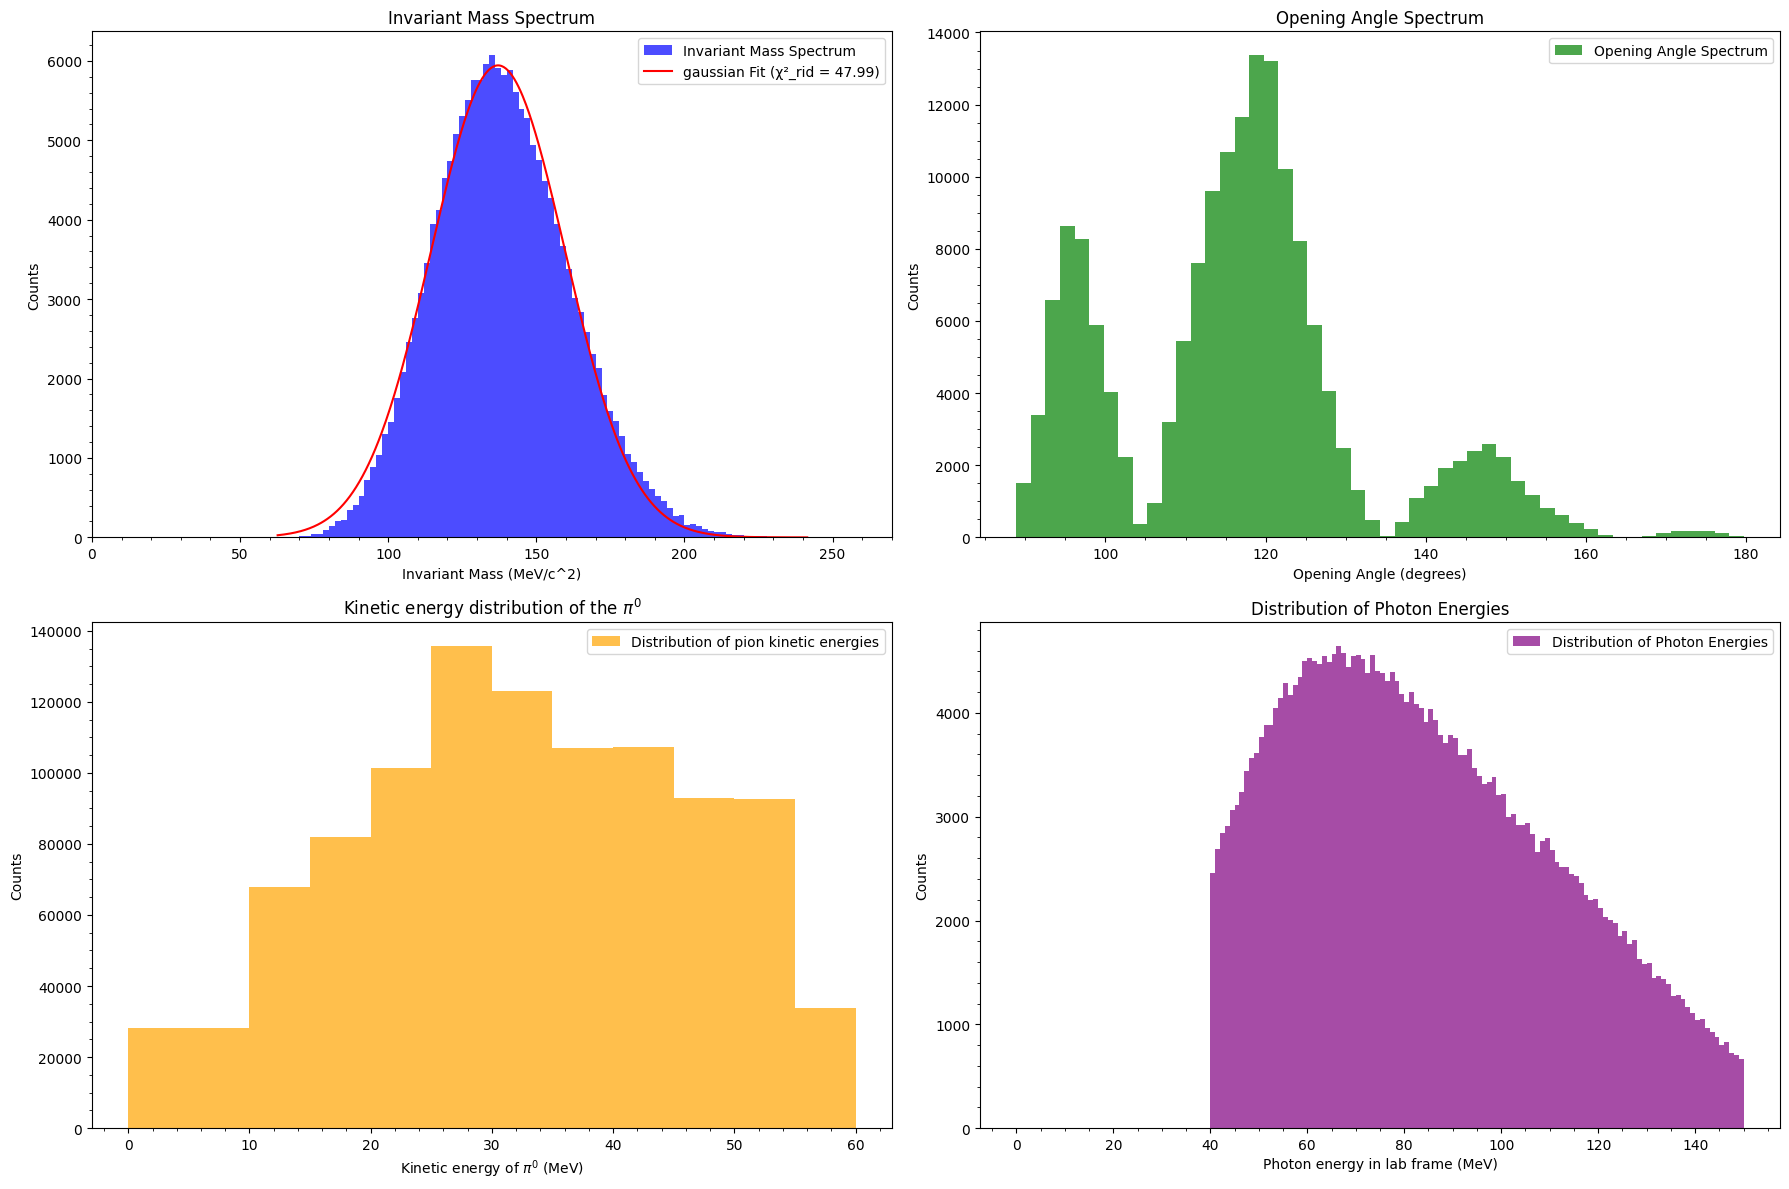

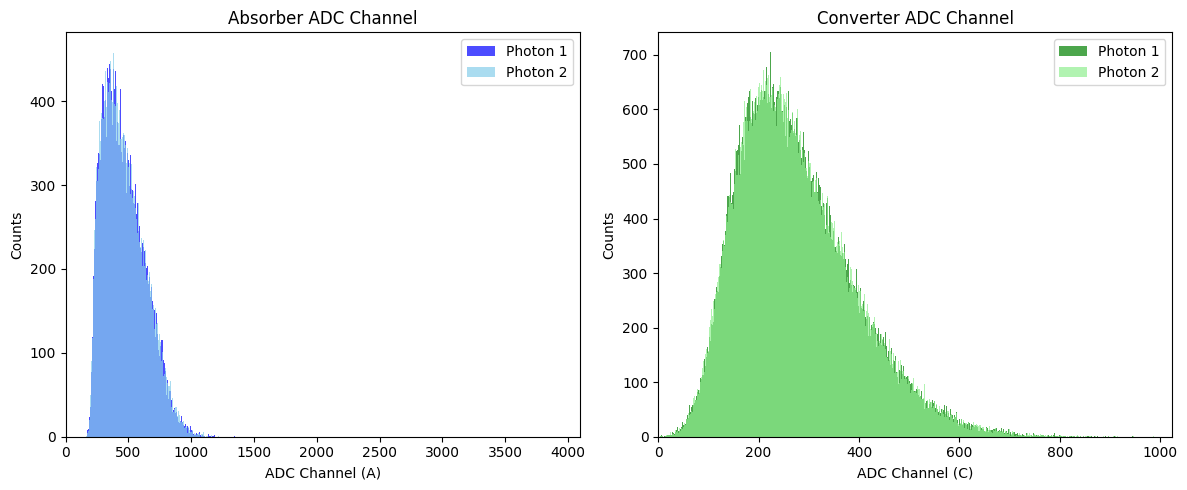

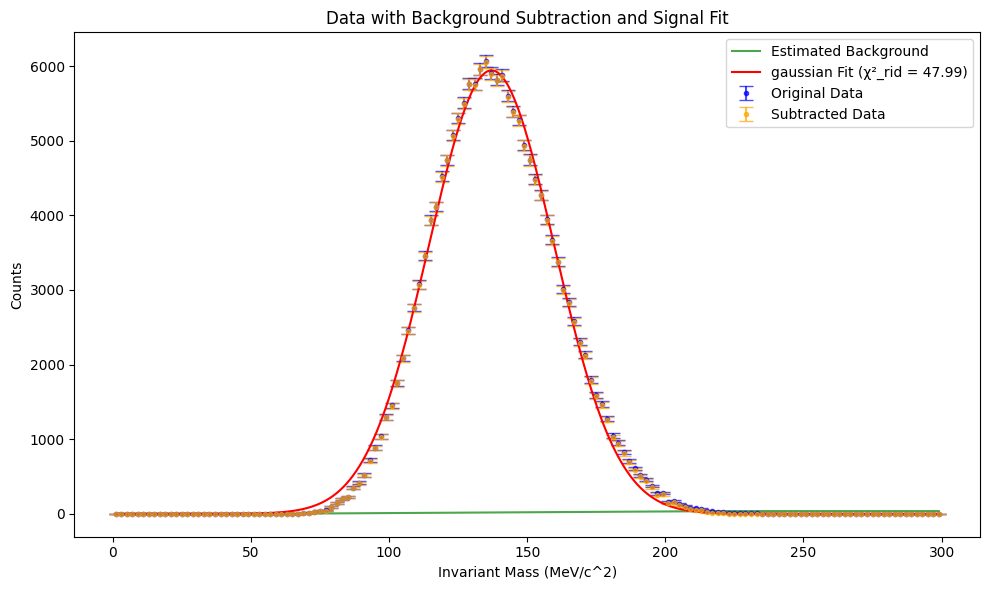

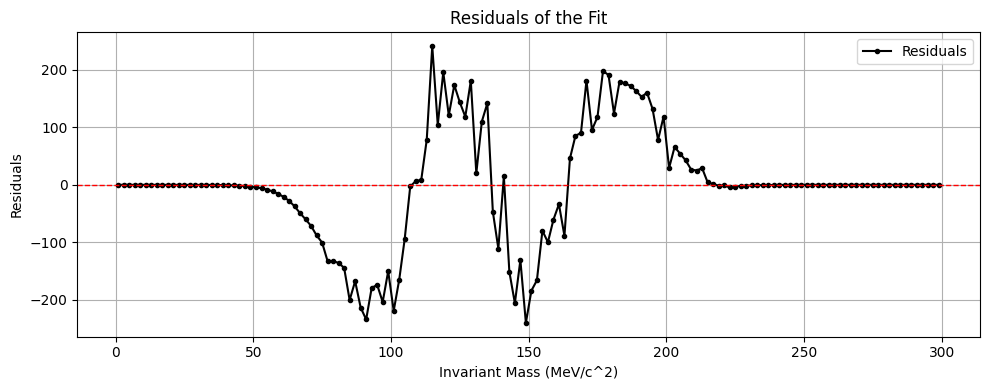

In [11]:
from IPython import get_ipython
from IPython.display import display
# %%
from IPython import get_ipython
from IPython.display import display
# %%
import matplotlib.ticker as ticker
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

# --- Costanti fisiche ---
M_PI0 = 134.9766  # MeV/c^2

# --- Funzioni di utilità (Numba-compatibili) ---

@jit(nopython=True)
def is_accepted(theta, phi, bounds):
    """Verifica se un dato angolo è dentro l'accettanza del rivelatore."""
    for i in range(bounds.shape[0]):
        phi_min, phi_max, theta_min, theta_max = bounds[i]
        if (phi_min <= phi <= phi_max) and (theta_min <= theta <= theta_max):
            return True
    return False

@jit(nopython=True)
def sample_isotropic_angles(num_samples):
    """Genera angoli isotropi (cos(theta) e phi)."""
    cos_theta = np.random.uniform(-1, 1, num_samples)  # Distribuzione uniforme in cos(theta)
    phi = np.random.uniform(0, 2 * np.pi, num_samples) # Distribuzione uniforme in phi
    return cos_theta, phi

@jit(nopython=True)
def boost_lab_frame(vectors, beta):
    """Applica il boost di Lorentz ai quadrivettori."""
    gamma = 1 / np.sqrt(1 - beta**2)
    # Gestione migliorata di gamma infinito
    gamma = np.where(np.isinf(gamma), 1e10, gamma)  # Sostituisci inf con un numero grande

    boosted_vectors = np.empty_like(vectors)
    boosted_vectors[:, 0] = gamma * (vectors[:, 0] - beta * vectors[:, 3])
    boosted_vectors[:, 1] = vectors[:, 1]
    boosted_vectors[:, 2] = vectors[:, 2]
    boosted_vectors[:, 3] = gamma * (vectors[:, 3] - beta * vectors[:, 0])
    return boosted_vectors

# --- Funzione per la dispersione in energia (sostituisce simulate_energy_calibration) ---
@jit(nopython=True)
def detector_energy_smearing(true_energy, a_params, a_prime_params, b0, resolution_params, adc_channels):
    """
    Simula la dispersione in energia e la ripartizione tra assorbitore e convertitore.
    """
    alpha1, alpha2 = a_params
    beta1, beta2 = a_prime_params
    a_E = alpha1 * true_energy + alpha2
    a_prime_E = beta1 * true_energy + beta2

    k, c = resolution_params
    sigma_E = k * np.sqrt(true_energy) + abs(c)  # Risoluzione in energia. Usa abs(c)

    measured_energy_preADC = np.random.normal(true_energy, sigma_E) # Campiona l'energia con la risoluzione

    # Return np.nan for all values if energy is negative to ensure consistent type
    if measured_energy_preADC <= 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # --- Ripartizione dell'energia tra assorbitore e convertitore ---
    converter_fraction_mean = 0.2  # Frazione *media* dell'energia nel convertitore (da calibrare!)
    converter_fraction_sigma = 0.05 # Fluttuazione (dev. standard) della frazione (da calibrare!)

    # Campiona la frazione di energia nel convertitore da una gaussiana troncata tra 0 e 1
    converter_fraction = np.random.normal(converter_fraction_mean, converter_fraction_sigma)
    converter_fraction = max(0.0, min(converter_fraction, 1.0))  # Tronca tra 0 e 1

    energy_converter = measured_energy_preADC * converter_fraction
    energy_absorber = measured_energy_preADC * (1 - converter_fraction)

    # --- Simulazione ADC (con valori attesi) ---
    adc_A_channels, adc_C_channels = adc_channels

    # Calcola i valori *attesi* dei canali ADC, in base all'energia depositata
    expected_A = (energy_absorber - b0) / a_E  if a_E!=0 else 0 #usa l'energia depositata
    expected_C = energy_converter / a_prime_E if a_prime_E!=0 else 0

     # Calcola la deviazione standard *separatamente* per A e C, usando abs(c)
    sigma_A = k * np.sqrt(max(0, expected_A)) + abs(c)
    sigma_C = k * np.sqrt(max(0, expected_C)) + abs(c)

    # Aggiungi il rumore (gaussiano) e arrotonda all'intero più vicino
    A_simulated = int(np.round(np.random.normal(expected_A, sigma_A)))
    C_simulated = int(np.round(np.random.normal(expected_C, sigma_C)))

    # Assicurati che i canali ADC siano entro i limiti
    A_simulated = max(0, min(A_simulated, adc_A_channels))
    C_simulated = max(0, min(C_simulated, adc_C_channels))

    # Calcola l'energia *ricostruita* usando i canali ADC simulati
    reconstructed_energy = a_E * A_simulated + a_prime_E * C_simulated + b0

    # Always return a tuple of 11 elements
    return reconstructed_energy, A_simulated, C_simulated, true_energy, a_E, a_prime_E, converter_fraction, energy_absorber, energy_converter, expected_A, expected_C

@jit(nopython=True)
def calculate_invariant_mass(E1, E2, opening_angle):
    """Calcola la massa invariante."""
    if np.isnan(E1) or np.isnan(E2) or np.isnan(opening_angle):
        return np.nan  # Propaga l'errore se l'input non è valido
    if E1 <= 0 or E2 <= 0:
        return np.nan #Se l'energia è negativa, non è valida
    return 2.0 * np.sqrt(E1 * E2) * np.sin(opening_angle / 2.0)

# --- Funzioni per la simulazione (Numba-compatibili) ---

@jit(nopython=True)
def simulate_pi0_decay(E_pi0, num_samples):
    """Simula il decadimento del π⁰ nel sistema di riferimento del centro di massa."""
    cos_theta_cm, phi_cm = sample_isotropic_angles(num_samples)
    E_gamma_cms = M_PI0 / 2  # Energia di ciascun fotone nel CM
    photon1_cms = np.empty((num_samples, 4))  # Quadrivettore del primo fotone
    photon2_cms = np.empty((num_samples, 4))  # Quadrivettore del secondo fotone

    photon1_cms[:, 0] = E_gamma_cms
    photon1_cms[:, 1] = E_gamma_cms * np.sqrt(1 - cos_theta_cm**2) * np.cos(phi_cm)  # px
    photon1_cms[:, 2] = E_gamma_cms * np.sqrt(1 - cos_theta_cm**2) * np.sin(phi_cm)  # py
    photon1_cms[:, 3] = E_gamma_cms * cos_theta_cm  # pz

    photon2_cms[:, 0] = E_gamma_cms
    photon2_cms[:, 1] = -photon1_cms[:, 1]  # px (direzione opposta)
    photon2_cms[:, 2] = -photon1_cms[:, 2]  # py (direzione opposta)
    photon2_cms[:, 3] = -photon1_cms[:, 3]  # pz (direzione opposta)

    return photon1_cms, photon2_cms, E_gamma_cms

@jit(nopython=True)
def apply_detector_effects(photons_lab, theta_phi_bounds, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, apply_acceptance):
    """Applica gli effetti del rivelatore e restituisce i dati degli eventi accettati."""
    num_samples = photons_lab.shape[0] // 2  # Numero totale di eventi (coppie di fotoni)
    accepted_indices = np.empty(num_samples, dtype=np.int64) # Indici degli eventi accettati
    accepted_energies = np.empty((num_samples, 2), dtype=np.float64) # Energie dei fotoni accettati
    accepted_A = np.empty((num_samples, 2), dtype=np.int64)      # Canali A dei fotoni accettati
    accepted_C = np.empty((num_samples, 2), dtype=np.int64)      # Canali C dei fotoni accettati
    count = 0  # Contatore degli eventi accettati

    for i in range(num_samples):  # Cicla su TUTTI gli eventi (coppie di fotoni)
        #print(f"----- apply_detector_effects: Inizio evento {i} -----") #aggiunto
        photon1_lab = photons_lab[2 * i]      # Primo fotone dell'evento i
        photon2_lab = photons_lab[2 * i + 1]  # Secondo fotone dell'evento i
        #print(f"  Evento {i}: photon1_lab = {photon1_lab}")  # Stampa il quadrivettore completo
        #print(f"  Evento {i}: photon2_lab = {photon2_lab}")  # Stampa il quadrivettore completo


        photon_magnitudes1 = np.sqrt(np.sum(photon1_lab[1:] ** 2))
        photon_magnitudes2 = np.sqrt(np.sum(photon2_lab[1:] ** 2))
        theta_lab1 = np.arccos(photon1_lab[3] / photon_magnitudes1) if photon_magnitudes1 != 0 else 0.0
        theta_lab2 = np.arccos(photon2_lab[3] / photon_magnitudes2) if photon_magnitudes2 != 0 else 0.0
        phi_lab1 = np.arctan2(photon1_lab[2], photon1_lab[1]) % (2 * np.pi)  # % 2π per avere valori tra 0 e 2π
        phi_lab2 = np.arctan2(photon2_lab[2], photon2_lab[1]) % (2 * np.pi)

        #print(f"  Evento {i}: theta_lab1 = {theta_lab1}, phi_lab1 = {phi_lab1}") #aggiunto
        #print(f"  Evento {i}: theta_lab2 = {theta_lab2}, phi_lab2 = {phi_lab2}") #aggiunto

        # Controlla l'accettanza *PRIMA* di chiamare detector_energy_smearing
        accept1 = is_accepted(theta_lab1, phi_lab1, theta_phi_bounds) if apply_acceptance else True
        accept2 = is_accepted(theta_lab2, phi_lab2, theta_phi_bounds) if apply_acceptance else True

        #print(f"  Evento {i}: accept1 = {accept1}, accept2 = {accept2}") #aggiunto

        if accept1:
            #print(f"    Fotone 1 accettato. Energia vera: {photon1_lab[0]}")#aggiunto
            (E_gamma_lab_res1, A1, C1, true_energy1, a_E1, a_prime_E1,
             converter_fraction1, energy_absorber1, energy_converter1,
             expected_A1, expected_C1) = detector_energy_smearing(
                photon1_lab[0], a_params, a_prime_params, b0, resolution_params, adc_channels
            )

        else:
             # Assign None values to all expected return variables
             (E_gamma_lab_res1, A1, C1, true_energy1, a_E1, a_prime_E1,
              converter_fraction1, energy_absorber1, energy_converter1,
              expected_A1, expected_C1) = (None, None, None, None, None, None, None, None, None, None, None)

        if accept2:
            #print(f"    Fotone 2 accettato. Energia vera: {photon2_lab[0]}")#aggiunto
            (E_gamma_lab_res2, A2, C2, true_energy2, a_E2, a_prime_E2,
             converter_fraction2, energy_absorber2, energy_converter2,
             expected_A2, expected_C2) = detector_energy_smearing(
                photon2_lab[0], a_params, a_prime_params, b0, resolution_params, adc_channels
            )

        else:
            # Assign None values to all expected return variables
            (E_gamma_lab_res2, A2, C2, true_energy2, a_E2, a_prime_E2,
             converter_fraction2, energy_absorber2, energy_converter2,
             expected_A2, expected_C2) = (None, None, None, None, None, None, None, None, None, None, None)



        # Se *entrambi* i fotoni sono accettati, e le energie sono valide, salva i risultati
        if (accept1 and accept2 and E_gamma_lab_res1 is not None and
            E_gamma_lab_res2 is not None and E_gamma_lab_res1 >= E_gamma_min and
            E_gamma_lab_res2 >= E_gamma_min):

            accepted_indices[count] = i
            accepted_energies[count, 0] = E_gamma_lab_res1  # Energia del primo fotone
            accepted_energies[count, 1] = E_gamma_lab_res2  # Energia del secondo fotone
            accepted_A[count, 0] = A1
            accepted_A[count, 1] = A2
            accepted_C[count, 0] = C1
            accepted_C[count, 1] = C2

            count += 1  # Incrementa il contatore degli eventi accettati

    return accepted_indices[:count], accepted_energies[:count], accepted_A[:count], accepted_C[:count]

@jit(nopython=True)
def run_simulation(T_pi0_samples, theta_phi_bounds, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, m_pi0, apply_acceptance):
    """Esegue l'intera simulazione."""
    num_samples = len(T_pi0_samples)  # Numero di campioni di energia cinetica del pione
    E_pi0 = T_pi0_samples + m_pi0     # Energia totale del pione
    p_pi0 = np.sqrt(E_pi0**2 - m_pi0**2) # Impulso del pione
    beta = p_pi0 / E_pi0                # Beta del pione
    beta = np.clip(beta, -0.999999, 0.999999)  # Evita beta > 1 (non fisico)

    # Simula il decadimento nel CM e applica il boost al LAB
    photon1_cms, photon2_cms, E_gamma_cms = simulate_pi0_decay(E_pi0, num_samples)
    photon1_lab = boost_lab_frame(photon1_cms, beta)
    photon2_lab = boost_lab_frame(photon2_cms, beta)

    # Combina i fotoni in un unico array per facilitare il processamento
    photons_lab = np.empty((2 * num_samples, 4))
    photons_lab[::2] = photon1_lab  # Fotone 1
    photons_lab[1::2] = photon2_lab  # Fotone 2

    # Array per salvare le energie nel LAB *prima* degli effetti del rivelatore
    pre_detector_energies = np.empty((num_samples, 2), dtype=np.float64)

    # Salva le energie *PRIMA* di apply_detector_effects
    for i in range(num_samples):
      pre_detector_energies[i,0] = photons_lab[2*i,0]
      pre_detector_energies[i,1] = photons_lab[2*i + 1, 0]

    # Applica gli effetti del rivelatore (accettanza, risoluzione, ecc.)
    accepted_indices, accepted_calib_energies, accepted_A, accepted_C = apply_detector_effects(
        photons_lab, theta_phi_bounds, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, apply_acceptance
    )

    # Calcola la massa invariante e l'angolo di apertura *solo* per gli eventi accettati
    num_accepted = accepted_indices.shape[0]
    accepted_invariant_masses = np.empty(num_accepted, dtype=np.float64)
    accepted_opening_angles = np.empty(num_accepted, dtype=np.float64)
    accepted_photon_energies_lab = np.empty(2 * num_accepted, dtype=np.float64) #energie calibrate

    for i in range(num_accepted):
        idx = accepted_indices[i]  # Indice dell'evento accettato
        #print(f"----- run_simulation: Inizio evento accettato {i} (indice originale: {idx}) -----") #aggiunto
        photon1_lab = photons_lab[2 * idx]      # Primo fotone (dopo il boost)
        photon2_lab = photons_lab[2 * idx + 1]  # Secondo fotone (dopo il boost)

        E_gamma_lab_res1 = accepted_calib_energies[i, 0]  # Energia del primo fotone (calibrata)
        E_gamma_lab_res2 = accepted_calib_energies[i, 1]  # Energia del secondo fotone (calibrata)

        # Calcola l'angolo di apertura tra i due fotoni
        photon_magnitudes1 = np.sqrt(np.sum(photon1_lab[1:] ** 2))
        photon_magnitudes2 = np.sqrt(np.sum(photon2_lab[1:] ** 2))
        cos_opening_angle = (photon1_lab[1] * photon2_lab[1] +
                             photon1_lab[2] * photon2_lab[2] +
                             photon1_lab[3] * photon2_lab[3]) / (photon_magnitudes1 * photon_magnitudes2)
        cos_opening_angle = max(-1.0, min(cos_opening_angle, 1.0))  # Assicurati che sia tra -1 e 1
        opening_angle = np.arccos(cos_opening_angle)
        accepted_invariant_masses[i] = calculate_invariant_mass(E_gamma_lab_res1, E_gamma_lab_res2, opening_angle)
        accepted_opening_angles[i] = opening_angle
        accepted_photon_energies_lab[2 * i] = E_gamma_lab_res1          #<------ Indice corretto
        accepted_photon_energies_lab[2 * i + 1] = E_gamma_lab_res2    #<------ Indice corretto
    #print(f"----- run_simulation: Fine ciclo. Eventi accettati: {num_accepted} -----")#aggiunto
    return accepted_invariant_masses, accepted_opening_angles, accepted_photon_energies_lab, accepted_A, accepted_C, pre_detector_energies

@jit(nopython=True)
def generate_kinetic_energies(bins, counts, num_samples):
    """Campiona le energie cinetiche dei pioni da un istogramma fornito."""
    probabilities = counts / np.sum(counts)  # Normalizza le conte per ottenere probabilità
    cumulative_prob = np.cumsum(probabilities)  # Calcola la probabilità cumulativa
    random_values = np.random.random(num_samples)  # Genera valori casuali uniformi
    sampled_bins = np.searchsorted(cumulative_prob, random_values) # Trova il bin corrispondente
    sampled_bins = np.clip(sampled_bins, 0, len(bins) - 2)  # Assicurati che l'indice sia valido
    bin_width = np.diff(bins)  # Calcola la larghezza dei bin
    random_shift = np.random.uniform(0, 1, len(sampled_bins)) * bin_width[sampled_bins] # Campiona uniformemente all'interno del bin
    T_pi0_samples = bins[sampled_bins] + random_shift   # Calcola l'energia cinetica campionata
    return T_pi0_samples

# --- Funzioni per il fitting e il plotting (non Numba-compatibili) ---

def gaussian(m, A, m0, sigma):
    """Funzione gaussiana."""
    return A * np.exp(-(m - m0)**2 / (2 * sigma**2))

def lorentzian(m, A, m0, Gamma):
    """Funzione lorentziana."""
    return A * (Gamma / 2)**2 / ((m - m0)**2 + (Gamma / 2)**2)

def fit_signal(m_data, counts, model_function, initial_guess):
    """Esegue il fit dei dati usando una funzione modello specificata."""
    try:
        popt, pcov = curve_fit(model_function, m_data, counts, p0=initial_guess)
        perr = np.sqrt(np.diag(pcov))  # Errori sui parametri (radice quadrata della diagonale della covarianza)
        residuals = counts - model_function(m_data, *popt)  # Residui del fit
        chi_squared = np.sum(residuals**2 / counts,where=counts>0)  # Calcola il chi-quadro
        dof = len(m_data) - len(initial_guess)  # Gradi di libertà
        chi2_reduced = chi_squared / dof if dof > 0 else np.inf # Chi-quadro ridotto
        return popt, perr, chi2_reduced, residuals, m_data #Restituisci i risultati
    except RuntimeError as e:
        print(f"Fit error: {e}")
        return None, None, None, None, None  # Restituisci None se il fit fallisce

def estimate_background_from_sidebands(m_data, counts, left_sideband, right_sideband):
    """Stima il fondo usando le bande laterali."""
    left_mask = (m_data >= left_sideband[0]) & (m_data <= left_sideband[1])
    right_mask = (m_data >= right_sideband[0]) & (m_data <= right_sideband[1])

    left_count = np.sum(counts[left_mask])
    right_count = np.sum(counts[right_mask])

    left_width = left_sideband[1] - left_sideband[0]
    right_width = right_sideband[1] - right_sideband[0]

    if left_width <= 0 or right_width <= 0:
        print("Warning: Sideband width is zero or negative.")
        return np.zeros_like(m_data)

    if left_count == 0 and right_count == 0:
        return np.zeros_like(m_data)

    if left_count > 0 and right_count > 0:
        left_mean = np.mean(m_data[left_mask])
        right_mean = np.mean(m_data[right_mask])
        if np.isnan(left_mean) or np.isnan(right_mean):
            return np.zeros_like(m_data)
        background_level = np.interp(m_data, [left_mean, right_mean],
                                     [left_count / left_width, right_count / right_width])
    elif left_count > 0:
        background_level = np.full_like(m_data, left_count / left_width)
    elif right_count > 0:
        background_level = np.full_like(m_data, right_count / right_width)
    else:
        return np.zeros_like(m_data)

    return background_level

def subtract_background(counts, background_estimate):
    """Sottrae il fondo stimato dai conteggi."""
    background_estimate = np.nan_to_num(background_estimate, nan=0.0)  # Gestisci i NaN
    result = counts - background_estimate
    return np.maximum(0, result)  # Evita conteggi negativi


def plot_results(masses, angles, photon_energies_lab, T_pi0_samples, pi0_bins, accepted_A, accepted_C, fit_parameters=None,
                 fit_errors=None, chi2_reduced=None, left_sideband=None,
                 right_sideband=None, background_estimate=None, counts=None,
                 counts_subtracted=None, model_name=None,
                 residuals=None, m_data_fit=None):
    """Genera e visualizza i grafici dei risultati della simulazione."""

    # --- Massa Invariante, Angolo di Apertura, ed Energia del Pione ---
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 2, 1)
    mass_bins = np.linspace(0, 300, 151)
    plt.hist(masses, bins=mass_bins, color='blue', alpha=0.7, label='Invariant Mass Spectrum')

    if fit_parameters is not None:
        m_fit = np.linspace(min(masses), max(masses), 500)
        if model_name == "gaussian":
            fit_curve = gaussian(m_fit, *fit_parameters)
        elif model_name == "lorentzian":
            fit_curve = lorentzian(m_fit, *fit_parameters)
        plt.plot(m_fit, fit_curve, 'r-', label=f'{model_name} Fit (χ²_rid = {chi2_reduced:.2f})')

    plt.xlabel('Invariant Mass (MeV/c^2)')
    plt.ylabel('Counts')
    plt.title('Invariant Mass Spectrum')
    plt.legend()
    ax = plt.gca()
    plt.xlim(0, 270)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(2, 2, 2)
    plt.hist(np.degrees(angles), bins=50, color='green', alpha=0.7, label='Opening Angle Spectrum')
    plt.xlabel('Opening Angle (degrees)')
    plt.ylabel('Counts')
    plt.title('Opening Angle Spectrum')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(2, 2, 3)
    plt.hist(T_pi0_samples, bins=pi0_bins, color='orange', alpha=0.7, label='Distribution of pion kinetic energies')
    plt.xlabel("Kinetic energy of $\\pi^0$ (MeV)")
    plt.ylabel("Counts")
    plt.title("Kinetic energy distribution of the $\\pi^0$")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(2, 2, 4)
    photon_bins = np.linspace(0, 150, 151) + 0.0001
    plt.hist(photon_energies_lab, bins=photon_bins, color='purple', alpha=0.7, label='Distribution of Photon Energies')
    plt.xlabel('Photon energy in lab frame (MeV)')
    plt.ylabel('Counts')
    plt.title('Distribution of Photon Energies')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.tight_layout()
    plt.show()

    # --- Distribuzioni dei Canali ADC (MODIFICATO) ---
    plt.figure(figsize=(12, 5))  # Una sola riga, due colonne

    plt.subplot(1, 2, 1)  # Assorbitore
    plt.hist(accepted_A[:, 0], bins=np.arange(0, 4097), color='blue', alpha=0.7, label='Photon 1')
    plt.hist(accepted_A[:, 1], bins=np.arange(0, 4097), color='skyblue', alpha=0.7, label='Photon 2')
    plt.xlabel('ADC Channel (A)')
    plt.ylabel('Counts')
    plt.title('Absorber ADC Channel')
    plt.xlim(0, 4096)
    plt.legend()  # Aggiungi la legenda

    plt.subplot(1, 2, 2)  # Convertitore
    plt.hist(accepted_C[:, 0], bins=np.arange(0, 1025), color='green', alpha=0.7, label='Photon 1')
    plt.hist(accepted_C[:, 1], bins=np.arange(0, 1025), color='lightgreen', alpha=0.7, label='Photon 2')
    plt.xlabel('ADC Channel (C)')
    plt.ylabel('Counts')
    plt.title('Converter ADC Channel')
    plt.xlim(0, 1024)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Resto della funzione (background subtraction, ecc.) --- Rimane invariato
    if counts_subtracted is not None and background_estimate is not None:
        m_data = (mass_bins[:-1] + mass_bins[1:]) / 2
        counts, _ = np.histogram(masses, bins=mass_bins)
        plt.figure(figsize=(10, 6))
        plt.errorbar(m_data, counts, yerr=np.sqrt(np.abs(counts)), fmt='.', label='Original Data', capsize=5, color='blue', alpha=0.7)
        bin_widths = np.diff(mass_bins)
        plt.plot(m_data, background_estimate * bin_widths, '-', label='Estimated Background', color='green', alpha=0.7)
        plt.errorbar(m_data, counts_subtracted, yerr=np.sqrt(np.abs(counts_subtracted)), fmt='.', label='Subtracted Data', capsize=5, color='orange', alpha=0.7)
        if fit_parameters is not None:
            m_fit = np.linspace(min(m_data), max(m_data), 500)
            if model_name == "gaussian":
                fit_curve = gaussian(m_fit, *fit_parameters)
            elif model_name == "lorentzian":
                fit_curve = lorentzian(m_fit, *fit_parameters)
            plt.plot(m_fit, fit_curve, 'r-', label=f'{model_name} Fit (χ²_rid = {chi2_reduced:.2f})')
        plt.xlabel("Invariant Mass (MeV/c^2)")
        plt.ylabel('Counts')
        plt.title('Data with Background Subtraction and Signal Fit')
        plt.legend()
        plt.tight_layout()
        plt.show()

        if residuals is not None and m_data_fit is not None:
            plt.figure(figsize=(10, 4))
            plt.plot(m_data_fit, residuals, marker='.', linestyle='-', label='Residuals', color='black')
            plt.axhline(0, color='red', linestyle='--', linewidth=1)
            plt.xlabel('Invariant Mass (MeV/c^2)')
            plt.ylabel('Residuals')
            plt.title('Residuals of the Fit')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


# --- Funzione Principale ---

def main():
    """Funzione principale per eseguire la simulazione."""
    num_samples = 1000000
    E_gamma_min = 40.0  # Soglia minima di energia per i fotoni (MeV)
    sigma_theta = 0.08163  # Non più utilizzato direttamente

    # --- Parametri di Calibrazione (presi dal testo) e per la risoluzione ---
    a_params = (-5.8e-5, 0.154)       # Parametri per a(E)
    a_prime_params = (8.34e-5, 0.055)  # Parametri per a'(E)
    b0 = -0.3                         # Offset (MeV)
   # k = 0.05  # Esempio: 5% a 1 GeV  <--  *ADATTA QUESTO VALORE*
   # c = 1.0   # Esempio: Risoluzione minima di 1 MeV  <-- *ADATTA QUESTO VALORE*
    k = 1.6806                           #<----- Valori calibrati sperimentalmente
    c = -4.9133
    resolution_params = (k, c)
    adc_channels = (4096, 1024)      # Numero di canali ADC (Assorbitore, Convertitore)

    # --- Definizione dell'accettanza angolare (esempio) ---
    theta_phi_bounds_np = np.array([
        [0, 3.2705, 0.5079, 0.6091],
        [0, 6.3402, 0.9477, 1.1467],
        [0, 8.1301, 1.4434, 1.6982],
        [0, 8.1301, 1.9670, 2.2218],
        [0, 8.1301, 2.4906, 2.7454],
        [0, 8.1301, 3.7926, 3.5378],
        [0, 8.1301, 4.3162, 4.0614],
        [0, 8.1301, 4.8398, 4.5850],
        [0, 6.3402, 5.3355, 5.1365],
        [0, 3.2705, 5.7753, 5.6741],
    ])
    apply_acceptance = True  # Applica l'accettanza angolare

    seed = 42
    np.random.seed(seed)

    # --- Generazione delle energie cinetiche dei pioni (da un istogramma) ---
    pi0_bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], dtype=np.float64)
    counts = np.array([5, 5, 12, 14.5, 18, 24, 22, 19, 19, 16.5, 16.5, 6], dtype=np.float64)
    T_pi0_samples = generate_kinetic_energies(pi0_bins, counts, num_samples)

    print("T_pi0_samples: min =", np.min(T_pi0_samples), "MeV")
    print("T_pi0_samples: max =", np.max(T_pi0_samples), "MeV")
    print("T_pi0_samples: mean =", np.mean(T_pi0_samples), "MeV")
    print("T_pi0_samples: std =", np.std(T_pi0_samples), "MeV")

    # --- Esegui la simulazione COMPLETA ---
    masses, angles, photon_energies_lab, accepted_A, accepted_C, pre_detector_energies = run_simulation(
        T_pi0_samples, theta_phi_bounds_np, E_gamma_min, a_params, a_prime_params, b0, resolution_params, adc_channels, M_PI0, apply_acceptance
    )

    # Stampa le energie (fuori da run_simulation, quindi fuori da Numba)
    for i in range(min(10, len(pre_detector_energies))):  # Stampa i primi 10 eventi
      print(f"Evento {i}: E_gamma1 (LAB) = {pre_detector_energies[i, 0]:.2f} MeV, E_gamma2 (LAB) = {pre_detector_energies[i, 1]:.2f} MeV")


    # --- Analisi e Plotting ---

    # Definisci le bande laterali per la stima del fondo
    left_sideband = (50, 65)
    right_sideband = (210, 225)

    # Definisci i bin per l'istogramma della massa invariante
    mass_bins = np.linspace(0, 300, 151) + 0.0001

    # Crea l'istogramma della massa invariante
    hist_masses, bin_edges_masses = np.histogram(masses, bins=mass_bins)
    m_data = (bin_edges_masses[:-1] + bin_edges_masses[1:]) / 2  # Centri dei bin
    counts_original = hist_masses  # Conteggi originali

    # Stima e sottrai il fondo
    background_estimate = estimate_background_from_sidebands(m_data, counts_original, left_sideband, right_sideband)
    counts_subtracted = subtract_background(counts_original, background_estimate)

    # --- Fitting ---

    # Scegli il modello di fit (gaussiana o lorentziana)
    model_function = gaussian  # Puoi cambiare in 'lorentzian' se preferisci

    # Fornisci una stima iniziale dei parametri del fit
    initial_guess = [10000, 135, 10]  # Ampiezza, media, dev. standard (o larghezza per Lorentziana)

    # Esegui il fit
    fit_parameters, fit_errors, chi2_reduced, residuals, m_data_fit = fit_signal(m_data, counts_subtracted, model_function, initial_guess)

    # Stampa i risultati del fit
    if fit_parameters is not None:
        print(f"Fit Results ({model_function.__name__}):")
        print(f"  Parameters: {fit_parameters}")
        print(f"  Errors: {fit_errors}")
        print(f"  Reduced Chi-squared: {chi2_reduced:.2f}")
        if model_function.__name__ == "gaussian":
            fwhm = 2 * np.sqrt(2 * np.log(2)) * fit_parameters[2]
            fwhm_error = 2 * np.sqrt(2 * np.log(2)) * fit_errors[2]
            print(f"  FWHM: {fwhm:.2f} ± {fwhm_error:.2f} MeV/c^2")

            # Trova il picco
            max_bin_index = np.argmax(hist_masses)
            # Calcola il centro del bin
            max_bin_center = (bin_edges_masses[max_bin_index] + bin_edges_masses[max_bin_index+1]) / 2
            error_max_mass = np.std(masses)  # Questa è la *deviazione standard* della distribuzione, *NON* l'errore sul valor medio del fit!
            print(f"Maximum of invariant mass spectrum: {max_bin_center:.2f} MeV/c^2 +/- {error_max_mass:.2f} MeV/c^2")
    else:
        print("Fit failed.")

    variance = np.var(masses)
    skewness = stats.skew(masses)

    print(f"Invariant mass spectrum variance: {variance:.2f} (MeV/c^2)^2")
    print(f"Invariant mass spectrum skewness: {skewness:.2f}")

    # --- Plotting ---

    # Chiama la funzione per generare i grafici
    plot_results(masses, angles, photon_energies_lab, T_pi0_samples, pi0_bins, accepted_A, accepted_C,
                 fit_parameters=fit_parameters, fit_errors=fit_errors,
                 chi2_reduced=chi2_reduced, left_sideband=left_sideband,
                 right_sideband=right_sideband,
                 background_estimate=background_estimate,
                 counts=counts_original, counts_subtracted=counts_subtracted,
                 model_name=model_function.__name__,
                 residuals=residuals, m_data_fit=m_data_fit)

if __name__ == "__main__":
    main()